<img src="https://gist.githubusercontent.com/jakubczakon/10e5eb3d5024cc30cdb056d5acd3d92f/raw/5c464c16ccbc7150b4025e0a2a05b84ab99a7bc3/logo_DS_AI.png" alt="Drawing" width="600"/>

# PoweR x deepsense.ai

## Case study - wykrywanie ryzyka udaru
Według Światowej organizacji zdrowia udar jest 2. z kolei najczęstszą przyczyną śmierci na świecie (11% z ogólnej liczby zgonów). 
Naszym celem jest ocena ryzyka wystąpienia udaru u pacjenta na podstawie takich parametrów jak płeć, wiek, BMI, występowanie pewnych chorób, itp.

Stworzenie algorytmu działającego z wysoką skutecznością pozwoliłoby na wczesną detekcję możliwości wystąpienia udaru i zastosowanie odpowiedniego leczenia / wskazań dla pacjenta.

In [ ]:
!pip install pandas-profiling==3.1.0 --quiet
!pip install eli5 --quiet
!pip install shap --quiet
!pip install tensorboard --quiet

In [ ]:
import os
import io
from datetime import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, LabelEncoder

## Pierwsze spojrzenie na dane

Zanim dokonamy **jakiegokolwiek** uczenia maszynowego - kluczowe jest, aby zaznajomić się z danymi. Przeczytanie opisu danych jest istotne, lecz nie jest wystarczające!

Problemy które możemy napotkać:

* brakujące wartości (czy są? jak często? skorelowane?),
* różne formaty danych (np. kod pocztowy w różnych formatach stringów),
* brak konsekwencji w oznaczeniach (np. "USA" i "United States of America" jako oznaczenia tego samego kraju),
* dane nie są zbalansowane,
* odstające wartości,
* jednostki (np. czas w sekundach, dochód w lokalnej walucie).

Estymuje się, że około 80% pracy osoby na stanowisku Data Scientist opiera się na czyszczeniu, przetwarzaniu i przygotowywaniu danych.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/mcszk/uczenie-maszynowe-w-medycynie/main/data/healthcare-dataset-stroke-data.csv', delimiter = ',', encoding = 'utf-8')
data.head(3).T

In [ ]:
# typy danych
data.info()

In [ ]:
data.describe(exclude = 'object')

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title='Stroke Prediction Dataset')
profile

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
sns.heatmap(data.corr(), annot=True)

In [ ]:
data

In [ ]:
sns.jointplot(data=data, x="age", y="bmi")

In [ ]:
sns.displot(x='age', hue='stroke', data=data, alpha=0.5)

In [ ]:
sns.pairplot(data,hue='stroke',palette='Dark2');
plt.tight_layout()

## Przetwarzanie danych

In [ ]:
data

In [ ]:
data_copy = data.copy()

X = data.drop(['stroke','id'], axis = 1)
y = data['stroke']

nominal = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] 

# enkodowanie one-hot 
temp = X.drop(columns = nominal)
dummies = pd.get_dummies(X[nominal])
X = pd.concat([temp,dummies], axis = 1)
X

In [ ]:
# brakujące wartości?
X.isnull().sum()

Istnieje kilka sposobów na radzenie sobie z brakującymi danymi:
- usunięcie wierszy z brakującymi danymi
- usunięcie kolumn z dużymi brakami danych
- wypełnienie braków średnią/medianą z pozostałych danych
- użycie bardziej skomplikowanych sposobów np. MICE

MICE - Multiple Imputation by Chained Equations.

Opis algorytmu MICE w kilku krokach:
1. Zastępujemy brakujące dane (dla każdej zmiennej która ma braki) przez chwilowy 'wypełniacz' np. średnią. Jeśli mamy brakujące dane dla wieku oraz indeksu bmi - wypełniamy braki średnią wieku i średnią bmi.
2. Wybieramy jedną ze zmiennych i zamieniamy wypełnione wartości z powrotem na brakujące (ale tylko dla tej jednej zmiennej, np. dla wieku).
3. Dokonujemy regresji dla wieku korzystając z innych zmiennych (objaśniających) które miały braki (u nas - cecha bmi). W tym celu nie bierzemy pod uwagę brakujących danych dla wieku.
4. Używamy naszego modelu do predykcji brakujących wartości wieku.
5. Powtarzamy kroki 2-4 dla innych cech z brakującymi danymi (u nas bmi).

In [ ]:
# przykładowy kod
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
train_mice = data.copy(deep=True)

mice_imputer = IterativeImputer()
new_bmi = mice_imputer.fit_transform(X)

In [ ]:
# uzupełnijmy
# to remove
X['bmi'] = X['bmi'].fillna(round(X['bmi'].median(),2))
X.isnull().sum()

## Podział na zbiór uczący i testowy

In [ ]:
# możemy łatwo dokonać podziału korzystając z gotowej funkcji
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 123)

## Zmniejszanie wymiarowości i wizualizacja

Analiza głównych składowych (Principal Component Analysis, PCA) 
Pozwala nam znaleźć najlepsze ustawienie kamery na dane - takie rzutowanie, które ograniczy liczbę wymiarów na które patrzymy ale zachowa jak najwięcej informacji o danych.

In [ ]:
X_for_viz = (X - X.mean()) / X.std()

In [ ]:
from sklearn.decomposition import PCA
data_pca = PCA(n_components= 2).fit_transform(X_for_viz)

In [ ]:
feature = "stroke"
data_to_plot_pca = pd.DataFrame(np.column_stack((data_pca ,data[feature])), columns=["x1", "x2", feature])
sns.lmplot(x="x1", y="x2", data=data_to_plot_pca, fit_reg=False, hue=feature, palette='Dark2', height=12)

t-SNE - t-distributed Stochastic Neighbor Embedding.

Wyliczamy rozkład odległości między punktami w oryginalnej wymiarowości.
Tworzymy 'losowy' rzut punktów na mniejszą podprzestrzeń (np. dwuwymiarową).
Ponownie obliczamy rozkład odległości. Chcemy, aby rozkład w wielu i w dwóch wymiarach były jak najbardziej podobne do siebie.

Poprawiamy nasz rzut iteracyjnie, korzystając z dywergencji Kullbacka-Leiblera jako funkcji straty i spadku podług gradientu.

![](https://zaburo-ch.github.io/images/mnist_process.gif)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=25, verbose=2, random_state=12)

In [ ]:
data_tsne = tsne.fit_transform(X_for_viz)

In [ ]:
data_tsne

In [ ]:
feature = "stroke"
data_to_plot_tsne = pd.DataFrame(np.column_stack((data_tsne, data[feature])), columns=["x1", "x2", feature])
sns.lmplot(x="x1", y="x2", data=data_to_plot_tsne, fit_reg=False, hue=feature, palette='Dark2', size=12)

## Sposoby radzenia sobie z niezbalansowanym zbiorem danych

Czemu przeszkada nam brak zbalansowania klas w zbiorze danych?

1. Znaczna część algorytmów uczenia maszynowego dostępnych w popularnych implementacjach korzysta z założenia równoliczności klas. Wobec tego, należy je często zmodyfikować aby móc z sukcesem zastosować je w problemach, gdzie tej równoliczności nie ma.
2. Brak zbalansowania zbioru danych może powodować niepoprawną interpretację metryk używanych do walidacji modelu. Najpopularniejszym przykładem jest tutaj *dokładność* (ang. *accuracy*).

![](https://i.redd.it/b60z0fe8xiu51.jpg)

Jak poradzić sobie z brakiem balansu klas?

1. Podpróbkowanie (*undersampling*) - wybieramy podzbiór obserwacji klasy większościowej tak, aby wyrównać liczbę obserwacji w klasach z których korzystamy
2. Nadpróbkowanie (*oversampling*) - *wygenerowanie* większej liczby obserwacji dla klasy mniejszościowej
3. Uwzględnienie ważenia obserwacji w funkcji straty w modelu który wykorzystujemy.

In [ ]:
# SMOTE 
from imblearn.over_sampling import SMOTE

SMOTE: Synthetic Minority Over-sampling Technique. Jest to technika pozwalająca na syntetyczne generowanie danych dla klasy mniejszościowej korzystająć z dostępnych obserwacji.

Jak działa SMOTE?:

    1. Z klasy mniejszościowej wybieramy losowo obserwację.
    2. Dla wybranej obserwacji znajdujemy k najbliższych sąsiadów.
    3. Wybieramy jednego z tych sąsiadów i wyznaczamy odcinek łączący początkową obserwację i losowo wybranego sąsiada.
       Losowo z odcinka wybieramy punkt, jest to syntetycznie stworzona obserwacja, którą będziemy zaliczać do mniej licznej z klas.
    4. Powtarzamy kroki 1-3, aż dane zostaną zbalansowane.

![](https://miro.medium.com/max/1400/1*6UFpLFl59O9e3e38ffTXJQ.png)

Inne opcje: ADASYN, borderline-SMOTE etc.

In [ ]:
# before SMOTE
print(f"{sum(y_train == 1)} and {sum(y_train == 0)}")

In [ ]:
smote = SMOTE(random_state=420)
X_train, y_train = smote.fit_resample(X_train ,y_train.ravel())

In [ ]:
# after SMOTE
print(f"{sum(y_train == 1)} and {sum(y_train == 0)}")

## Modelowanie - model bazowy

### Drzewo decyzyjne (ang. *decision tree*)

Zacznijmy od pojedynczego drzewa decyzyjnego.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 

In [ ]:
tree_classifier = DecisionTreeClassifier(max_depth = 5)

In [ ]:
tree_classifier.fit(X_train, y_train)

In [ ]:
print(f"Train accuracy: {tree_classifier.score(X_train, y_train):.3f}")
print(f"Test accuracy: {tree_classifier.score(X_test, y_test):.3f}")

In [ ]:
dot_data = tree.export_graphviz(tree_classifier)

In [ ]:
graph = graphviz.Source(dot_data)  

In [ ]:
graph.render("stroke_data")

In [ ]:
y_pred = tree_classifier.predict(X_test)
y_pred_proba = tree_classifier.predict_proba(X_test)[:, 1]

## Walidacja modelu

### Macierz pomyłek

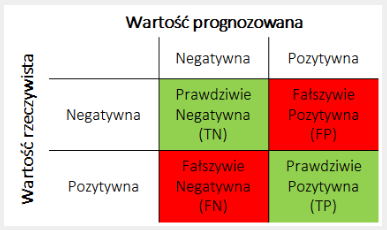

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
df_confusion = pd.DataFrame(conf_matrix)

df_confusion.index = ["no stroke", "stroke"]
df_confusion.index.name = "true value"

df_confusion.columns = ["no stroke", "stroke"]
df_confusion.columns.name = "predicted value"

sns.heatmap(df_confusion, linewidths=3, annot=True, fmt="d")

### Czułość, precyzja i F1

* Czułość (ang. recall / sensitivity) - zdolność modelu do wychwytywania przypadków pozytywnych - *TP/(TP+FN)*
* Precyzja (precision) - miara mówiąca o tym, jaka część predykcji "pozytywnych" była poprawna - *TP/(TP+FP)*
* Miara F1 (F1-Score) - średnia harmoniczna czułości i precyzji

In [ ]:
tn, fp, fn, tp = conf_matrix.reshape(-1)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
print(f"{tp} TP, {tn} TN, {fp} FP, {fn} FN\nprecision: {precision:.3f}\nrecall: {recall:.3f}\nF1: {f1:.3f}")

Czułość i precyzja modelu wydają się niskie - czy nasz model jest bezwartościowy?

Być może zazwyczaj nie da się dokładnie przewidzieć wystąpienia udaru na podstawie danych wejściowych.<br>W tym przypadku wydaje się bardziej sensowne, żeby nasz model przewidywał ryzyko prawodopodobieństwo wystąpienia udaru.<br>
Jak zmierzyć jakość takiego modelu?

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle("Predicted stroke probability vs. ground truth", fontsize=20)
ax.hist(y_pred_proba[y_test==0], label="GT - no stroke", alpha=0.5, bins=20, range=(0., 1.), density=True)
ax.hist(y_pred_proba[y_test==1], label="GT - stroke", alpha=0.5, bins=20, range=(0., 1.), edgecolor='black', linewidth=1., density=True)
ax.grid()
ax.set_ylabel("Ground truth", fontsize=14)
ax.set_xlabel("Predicted probability", fontsize=14)
ax.legend(fontsize=12)

### Strata logarytmiczna (ang. *log loss*)

Miara używana w problemach regresji logistycznej - gdy wartości zmiennej objaśnianej wskazują na wystąpienie, lub brak wystąpienia pewnego zdarzenia a model regresji logistycznej oblicza prawdopodobieństwo tego zdarzenia.

Dla pojedynczego punktu w danych stratę logarytmiczną wyraża wzór:

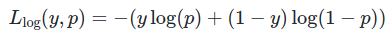

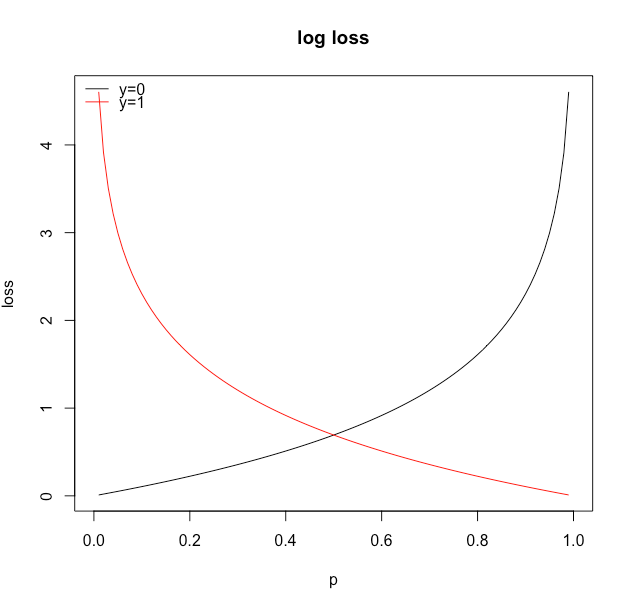

Im **niższa** wartość miary, tym **wyższa** jakość modelu.

In [ ]:
from sklearn.metrics import log_loss

model_log_loss = log_loss(y_test, y_pred_proba)
print(f"Log loss: {model_log_loss:.3f}")

### Krzywa ROC i miara AUC

In [ ]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(8, 8))
RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)
ax.grid()
plt.show()

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  confusion_matrix(y_test, y_pred)

  df_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
  df_confusion.index = ["no stroke", "stroke"]
  df_confusion.index.name = "true value"
  df_confusion.columns = ["no stroke", "stroke"]
  df_confusion.columns.name = "predicted value"
  fig, ax = plt.subplots(figsize=(8, 6))
  sns.heatmap(df_confusion, linewidths=3, annot=True, fmt="d", ax=ax)
  fig.suptitle("Confusion matrix", fontsize=16)
  return fig

def plot_roc(y_test, y_pred_proba):
  fig, ax = plt.subplots(figsize=(8, 8))
  RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=ax)
  ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)
  ax.grid()
  fig.suptitle("ROC Curve", fontsize=16)
  return fig


def plot_scores_distribution(y_test, y_pred_proba):
  fig, ax = plt.subplots(figsize=(16, 8))
  fig.suptitle("Predicted stroke probability vs. ground truth", fontsize=20)
  ax.hist(y_pred_proba[y_test==0], label="GT - no stroke", alpha=0.5, bins=20, range=(0., 1.), density=True)
  ax.hist(y_pred_proba[y_test==1], label="GT - stroke", alpha=0.5, bins=20, range=(0., 1.), edgecolor='black', linewidth=1., density=True)
  ax.grid()
  ax.set_ylabel("Ground truth", fontsize=14)
  ax.set_xlabel("Predicted probability", fontsize=14)
  ax.legend(fontsize=12)
  return fig

def validation_report(y_true, y_pred_proba, thr=0.5):
  y_pred = y_pred_proba >= thr

  model_log_loss = log_loss(y_true, y_pred_proba)
  print(f"Log loss: {model_log_loss:.3f}")
  print('---')

  confusion_matrix(y_test, y_pred)

  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  print(f"Precision: {precision:.3f}\nRecall: {recall:.3f}\nF1: {f1:.3f}")
  print('---')

  plot_confusion_matrix(y_test, y_pred).show()
  plot_roc(y_test, y_pred_proba).show()
  plot_scores_distribution(y_test, y_pred_proba)

validation_report(y_test, y_pred_proba)

## Śledzenie przebiegów trenowania modeli
### Tensorboard

In [ ]:
# Odkomentuj poniższą linię i uruchom komórkę, żeby wyczyścić katalog z logami tensorboarda

# ! rm -rf logs

In [ ]:
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

In [ ]:
experiment_name = 'baseline-' + datetime.now().strftime("%m-%d-%H:%M:%S")

def tensorboard_log_exp(exp_name, model, y_true, y_pred_proba, thr=0.5, logdir='logs'):
  y_pred = y_pred_proba >= thr

  file_writer = tf.summary.create_file_writer(os.path.join(logdir, exp_name))
  with file_writer.as_default(step=0):
      tf.summary.image("ROC", plot_to_image(plot_roc(y_test, y_pred_proba)))
      tf.summary.scalar('Log Loss', log_loss(y_true, y_pred_proba))
      tf.summary.scalar('F1 Score', f1_score(y_true, y_pred))
      tf.summary.scalar('Recall', recall_score(y_true, y_pred))
      tf.summary.scalar('Precision', precision_score(y_true, y_pred))
      tf.summary.text('Model', str(model))

tensorboard_log_exp(experiment_name, tree_classifier, y_test, y_pred_proba)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

### Las losowy (ang. *random forest*)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=12)

In [ ]:
random_forest_classifier.fit(X_train, y_train)

In [ ]:
y_pred_proba = random_forest_classifier.predict_proba(X_test)[:, 1]

In [ ]:
validation_report(y_test, y_pred_proba)

In [ ]:
experiment_name = 'rf-' + datetime.now().strftime("%m-%d-%H:%M:%S")

tensorboard_log_exp(experiment_name, random_forest_classifier, y_test, y_pred_proba)

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=12)

In [ ]:
xgb_model.fit(X_train, y_train)

In [ ]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
validation_report(y_test, y_pred_proba)

In [ ]:
experiment_name = 'xgb-' + datetime.now().strftime("%m-%d-%H:%M:%S")

tensorboard_log_exp(experiment_name, xgb_model, y_test, y_pred_proba)

![](https://ksopyla.com/wp-content/uploads/2018/12/Grid_search_vs_random_search_cross_validation.png)

Jak wybrać hiperparametry modelu tak, żeby zapewnić możliwie jak najlepszy wynik?

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
neg_to_pos_ratio = (y_train==0).sum() / (y_train==1).sum()

parameters = {
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 200],
    'reg_lambda': [0.1, 1, 10, 100],
    'subsample': [0.6, 1]
}
xgb_model_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=12),
                                     param_grid=parameters,
                                     scoring='neg_log_loss',
                                     cv=3,
                                     verbose=1,
                                     n_jobs=-1)

In [ ]:
xgb_model_grid_search.fit(X_train, y_train)

In [ ]:
xgb_model_grid_search.best_params_

In [ ]:
y_pred_proba = xgb_model_grid_search.predict_proba(X_test)[:, 1]

In [ ]:
validation_report(y_test, y_pred_proba)
# validation_report(y_test, y_pred_proba, thr=0.25)

In [ ]:
experiment_name = 'xgb-grid-search-' + datetime.now().strftime("%m-%d-%H:%M:%S")

tensorboard_log_exp(experiment_name, xgb_model_grid_search, y_test, y_pred_proba)

In [ ]:
%tensorboard --logdir logs

## Interpretacja i wytłumaczalność modelu

In [ ]:
import eli5

In [ ]:
# eli5.explain_weights(xgb_model.get_booster())
eli5.explain_weights(xgb_model_grid_search.best_estimator_.get_booster())

In [ ]:
xgb.plot_importance(xgb_model)

In [ ]:
graph = xgb.to_graphviz(xgb_model, num_trees=0)
graph

In [ ]:
import shap
shap.initjs()

In [ ]:
shap_values = shap.TreeExplainer(xgb_model_grid_search.best_estimator_).shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train)